In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
from timm import create_model

In [3]:
from fastai.vision.all import *

In [4]:
set_seed(999, reproducible=True)
BATCH_SIZE = 8

In [5]:
dataset_path = Path('../datasets/kaggle/petfinder/')
dataset_path.ls()

(#13) [Path('../datasets/kaggle/petfinder/train_5folds.csv'),Path('../datasets/kaggle/petfinder/train_10folds.csv'),Path('../datasets/kaggle/petfinder/test.csv'),Path('../datasets/kaggle/petfinder/train.csv'),Path('../datasets/kaggle/petfinder/test'),Path('../datasets/kaggle/petfinder/sample_submission.csv'),Path('../datasets/kaggle/petfinder/archive.zip'),Path('../datasets/kaggle/petfinder/.ipynb_checkpoints'),Path('../datasets/kaggle/petfinder/train'),Path('../datasets/kaggle/petfinder/crop')...]

In [6]:
df = pd.read_csv(dataset_path/'train.csv')
df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [7]:
df['path'] = df['Id'].map(lambda x:str(dataset_path/'train'/x)+'.jpg')
df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path
0,ebaaa8e384b3d2f0a56c7ff7675c154c,0,0,1,1,0,0,0,0,0,0,0,1,50,../datasets/kaggle/petfinder/train/ebaaa8e384b3d2f0a56c7ff7675c154c.jpg
1,25e3bf4267c2dc3f579b779418221bb7,0,1,1,1,0,1,0,1,0,0,1,0,25,../datasets/kaggle/petfinder/train/25e3bf4267c2dc3f579b779418221bb7.jpg
2,6548166fb3fda22b67881176397f0223,0,0,1,1,0,1,0,0,0,0,0,0,27,../datasets/kaggle/petfinder/train/6548166fb3fda22b67881176397f0223.jpg
3,472c40116e1833555715e4774445ae5b,0,1,1,1,0,0,0,0,1,1,0,0,19,../datasets/kaggle/petfinder/train/472c40116e1833555715e4774445ae5b.jpg
4,7b77e1a6d93667b575d57db83facd860,0,1,1,1,0,0,0,1,0,0,0,0,27,../datasets/kaggle/petfinder/train/7b77e1a6d93667b575d57db83facd860.jpg


In [8]:
len_df = len(df)
print(f"There are {len_df} images")

There are 9912 images


The mean Pawpularity score is 38.03904358353511
The median Pawpularity score is 33.0
The standard deviation of the Pawpularity score is 20.59199010577444


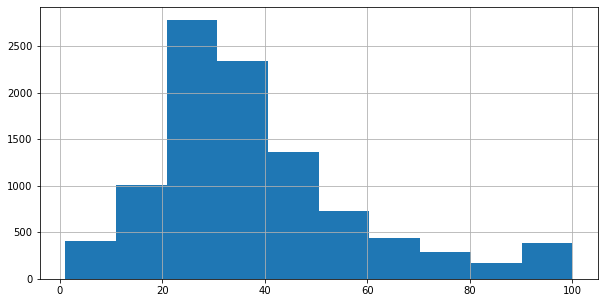

In [9]:
df['Pawpularity'].hist(figsize = (10, 5))
print(f"The mean Pawpularity score is {df['Pawpularity'].mean()}")
print(f"The median Pawpularity score is {df['Pawpularity'].median()}")
print(f"The standard deviation of the Pawpularity score is {df['Pawpularity'].std()}")

In [10]:
df['norm_score'] = df['Pawpularity']/100
df['norm_score']

0       0.50
1       0.25
2       0.27
3       0.19
4       0.27
        ... 
9907    0.26
9908    0.65
9909    0.38
9910    0.44
9911    0.62
Name: norm_score, Length: 9912, dtype: float64

In [11]:
seed=999
set_seed(seed, reproducible=True)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

In [12]:
#Sturges' rule
num_bins = int(np.floor(1+(3.3)*(np.log2(len(df)))))
# num_bins

<AxesSubplot:>

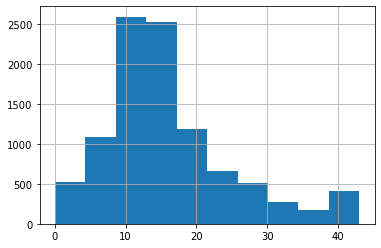

In [13]:
df['bins'] = pd.cut(df['norm_score'], bins=num_bins, labels=False)
df['bins'].hist()

In [14]:
import torch
import torch.nn as nn

# class PetModel(nn.Module):
#     def __init__(
#         self,
#         num_classes
#     ):
#         super().__init__()
#         self.model = create_model('swin_large_patch4_window7_224', num_classes=1, pretrained=True)
       

#     def forward(self, x):
#         pred = self.model(x)
       
#         return pred

# class PetModelForCB(nn.Module):
#     def __init__(
#         self,
#         num_classes
#     ):
#         super().__init__()
#         self.swin = create_model('swin_large_patch4_window7_224', num_classes=0, pretrained=True)
#         self.res2next = create_model('res2next50', num_classes=0, pretrained=True)
        
#         self.dropout = nn.Dropout(0.5)
#         self.dense1 = nn.Linear(self.swin.num_features + self.res2next.num_features, 128)
#         self.gelu = nn.GELU()
#         self.dense2 = nn.Linear(128, 1)
        
#     def forward(self, x):
#         swin_features = self.swin(x)
#         res2next_features = self.res2next(x)
#         features = torch.cat([swin_features, res2next_features], dim=1)
#         out = self.dense1(self.dropout(features))
#         out = self.gelu(out)
#         pred = self.dense2(out)
#         out = torch.cat([pred, features], dim=1)
#        return out


class PetModel(nn.Module):
    def __init__(
        self,
        num_classes
    ):
        super().__init__()
        self.model = create_model('vit_large_patch16_224', num_classes=num_classes, pretrained=True)

    def forward(self, x):
        features = self.model.forward_features(x)
        pred = self.model.head(features)
        return pred


# class PetModel(nn.Module):
#     def __init__(
#         self,
#         num_classes
#     ):
#         super().__init__()
#         self.model = create_model('tf_efficientnet_b0', num_classes=num_classes, pretrained=False)

#     def forward(self, x):
#         x = self.model.forward_features(x)
#         x = self.model.global_pool(x)
#         if self.model.drop_rate > 0.:
#             x = F.dropout(x, p=self.model.drop_rate, training=self.model.training)
#         return self.model.classifier(x)

# class PetModelForCB(nn.Module):
#     def __init__(
#         self,
#         num_classes
#     ):
#         super().__init__()
#         self.model = create_model('tf_efficientnet_b0', num_classes=num_classes, pretrained=False)

#     def forward(self, x):
#         self.eval()
#         features = self.model.forward_features(x)
#         features = self.model.global_pool(features)
#         if self.model.drop_rate > 0.:
#             features = F.dropout(features, p=self.model.drop_rate, training=self.model.training)
#         pred = self.model.classifier(features)
#         out = torch.cat([pred, features], dim=1)
#         return out

In [15]:
def petfinder_rmse(input,target):
    return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))

In [16]:
import gc
import torch
from sklearn.model_selection import KFold
from  sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVR

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

df['fold'] = -1

super_final_predictions = []
super_final_predictions2 = []
super_final_oof_predictions = []
super_final_oof_predictions2 = []
super_final_oof_true = []


N_FOLDS = 10
strat_kfold = StratifiedKFold(n_splits=N_FOLDS, random_state=seed, shuffle=True)
for fold, (idx, val_idx) in enumerate(strat_kfold.split(df.index, df['bins'])):
    train_df = df.loc[idx].reset_index(drop=True)
    val_df = df.loc[val_idx].reset_index(drop=True)

    dls = ImageDataLoaders.from_df(train_df, #pass in train DataFrame
                               valid_pct=0.2, #80-20 train-validation random split
                               seed=999, #seed
                               fn_col='path', #filename/path is in the second column of the DataFrame
                               label_col='norm_score', #label is in the first column of the DataFrame
                               y_block=RegressionBlock, #The type of target
                               bs=BATCH_SIZE, #pass in batch size
                               num_workers=8,
                               item_tfms=Resize(224), #pass in item_tfms
                               batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) #pass in batch_tfms

    model = PetModel(num_classes=1)

    learn = Learner(
        dls, 
        model, 
        loss_func=BCEWithLogitsLossFlat(), 
        metrics=petfinder_rmse,
        # model_dir = "tf_efficientnet_b0"
        model_dir = "vit_large_patch16_224_bs8_10fold_10epoch"
        # model_dir = "hybrid_bs8_20fold"
    ).to_fp16()
    # learn.load(f'tf_efficientnet_b0_fold{fold}')
    learn.load(f'vit_large_patch16_224_fold{fold}')


    val_dl = dls.test_dl(val_df)

    val_preds, _ = learn.tta(dl=val_dl, n=5, beta=0)
    # val_preds, _ = learn.get_preds(dl=val_dl)
    val_preds = val_preds.cpu().detach().numpy()
    
    final_test_predictions = []
    final_test_predictions.extend(val_preds[:,:1].ravel().tolist())
    
    final_test_predictions = [x * 100 for x in final_test_predictions]
    super_final_predictions.append(final_test_predictions)
    
    
    final_oof_true = val_df['Pawpularity'].values
    super_final_oof_true.append(final_oof_true)

    ##################
    # COMPUTE RSME
    rsme = np.sqrt(np.mean((super_final_oof_true[-1] - np.array(super_final_predictions[-1]))**2.0))
    print(f'Fold{fold+1} NN RSME =',rsme,'\n')


    gc.collect()
    torch.cuda.empty_cache()
    # if fold >= 1:
    #     break
    
    

/opt/conda/envs/rapids/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Fold1 NN RSME = 17.695806860330748 



/opt/conda/envs/rapids/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Fold2 NN RSME = 17.470670355905444 



/opt/conda/envs/rapids/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Fold3 NN RSME = 17.8757185721551 



/opt/conda/envs/rapids/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Fold4 NN RSME = 17.235157316626953 



/opt/conda/envs/rapids/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Fold5 NN RSME = 18.216877324727083 



/opt/conda/envs/rapids/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Fold6 NN RSME = 17.04528796310452 



/opt/conda/envs/rapids/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Fold7 NN RSME = 18.11620121491169 



/opt/conda/envs/rapids/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Fold8 NN RSME = 17.90581950643505 



/opt/conda/envs/rapids/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Fold9 NN RSME = 17.481153817089474 



/opt/conda/envs/rapids/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Fold10 NN RSME = 17.422237936313095 



In [17]:
true = np.hstack(super_final_oof_true)

oof = np.hstack(super_final_predictions)
rsme = np.sqrt( np.mean( (oof - true)**2.0 ))
print('Overall CV NN head RSME =',rsme)

Overall CV NN head RSME = 17.650183636440246


In [18]:
def my_mse(pred, gt):
    return np.sqrt(np.mean((pred-gt)**2))

In [19]:
high_thresholds = [48, 53, 58, 63, 68, 73, 78, 83, 88]
low_thresholds = [22,20,18,16,14,12,10,8,6]
weights = [0.5,0.55,0.60,0.65,0.7,0.75,0.8,0.85,0.9,0.95]

val_preds = oof.copy()
mse = my_mse(val_preds, true)
best_mse = float("inf")
print("original mse:{}".format(mse))
for weight in weights:
    for high in high_thresholds:
        for low in low_thresholds:
            val_preds = oof.copy()
            for i in range(len(val_preds)):
                if val_preds[i] > high:
                    val_preds[i] = val_preds[i] * weight + 38 * (1-weight)
                elif val_preds[i] < low:
                    val_preds[i] = val_preds[i] * weight + 38 * (1-weight)
            mse = my_mse(val_preds, true)
            if mse < best_mse:
                best_mse = mse
                best_val_preds = val_preds.copy()
                print("low high mse:{},({},{}),weight:{}".format(mse, low, high, weight))
            
            val_preds = oof.copy()
            for i in range(len(val_preds)):
                if val_preds[i] > high:
                    val_preds[i] = val_preds[i] * weight
            mse = my_mse(val_preds, true)
            if mse < best_mse:
                best_mse = mse
                best_val_preds = val_preds.copy()
                print("high mse:{},({}, ),weight:{}".format(mse, high, weight))
            
            val_preds = oof.copy()
            for i in range(len(val_preds)):
                if val_preds[i] < low:
                    val_preds[i] = val_preds[i] * weight 
            mse = my_mse(val_preds, true)
            if mse < best_mse:
                best_mse = mse
                best_val_preds = val_preds.copy()
                print("low mse:{},(,{}),weight:{}".format(mse, low, weight))
print("best mse: ", best_mse)

original mse:17.650183636440246
low high mse:18.162684576954916,(22,48),weight:0.5
low mse:17.712000673923573,(,22),weight:0.5
low mse:17.66409687525398,(,20),weight:0.5
low mse:17.654209867753007,(,18),weight:0.5
low mse:17.650183636440246,(,16),weight:0.5
low high mse:17.648698460350815,(18,78),weight:0.5
low high mse:17.648637997100405,(16,78),weight:0.5
low high mse:17.648102041878584,(22,83),weight:0.5
low high mse:17.6431734213239,(20,83),weight:0.5
low high mse:17.638489826963703,(18,83),weight:0.5
low high mse:17.63842932871884,(16,83),weight:0.5
low high mse:17.63801294852223,(18,83),weight:0.55
low high mse:17.63790199330636,(18,83),weight:0.6
low high mse:17.637818167311,(22,78),weight:0.7
low high mse:17.635339088227934,(22,73),weight:0.75
low high mse:17.63282243439236,(22,73),weight:0.8
best mse:  17.63282243439236


In [20]:
"""
整体缩放，不区分猫狗
"""
# # model1
# gt_dog = []
# preds_dog = []
# for i in range(len(is_cat)):
#     #if is_cat.iloc[i] == 1:
#         gt_dog.append(all_val_gts[i])
#         preds_dog.append(super_final_predictions[i])

# gts = np.array(gt_dog)
# preds_dog = np.array(preds_dog)
# all_val_preds = preds_dog
# tt = all_val_gts.copy()
# val_preds = all_val_preds.copy()
# ori_mse = my_mse(val_preds, gts)
# print("original mse:{}".format(ori_mse))

best_val_preds = best_val_preds.copy()
ori_mse = my_mse(best_val_preds, true)
print("ori_mse: ", ori_mse)
weights = [0.95,0.96,0.97,0.98,0.99, 0.995, 1.005, 1.01,1.02,1.03,1.04,1.05]
for weight in weights:
    best_val_preds = best_val_preds.copy()
    best_val_preds_scale = best_val_preds * weight
    mse = my_mse(best_val_preds_scale, true)
    if mse < ori_mse:
        print("mse:{},weight:{}".format(mse, weight))

ori_mse:  17.63282243439236
mse:17.622577491906014,weight:1.005
mse:17.61442783352908,weight:1.01
mse:17.604425260660886,weight:1.02
mse:17.602829021767604,weight:1.03
mse:17.609641402844357,weight:1.04
mse:17.62485265356151,weight:1.05



# twins_svt_large

original mse:17.594138270329285

low high mse:17.578122379930882,(22,68),weight:0.9

# swin_large_patch4_window7_224_bs8_10fold_mixup

original mse:17.497151724532664

low high mse:17.477569999563013,(22,58),weight:0.9

mse:17.47613288651255,weight:1.005


# beit_large_patch16_224_bs8_10fold_10epoch

original mse:17.483404823625204

low mse:17.483404823625204,(,22),weight:0.5

mse:17.476423636273488,weight:1.01


# vit_large_patch16_224_bs8_10fold_10epoch

original mse:17.650183636440246

low high mse:17.63282243439236,(22,73),weight:0.8

mse:17.602829021767604,weight:1.03


